In [1]:
import numpy as np
import pandas as pd
import os
import argparse
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

from capstone_project.preprocessing import generate_dataloaders, load_data, split_data
from capstone_project.models.embedding_network import EmbeddingNetwork
from capstone_project.models.classification_network import ClassificationNetwork
from capstone_project.utils import *

import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
PROJECT_DIR = '/home/kyt237/learning_visual_embeddings/'
DATA_DIR,  PLOTS_DIR, LOGGING_DIR = 'data', 'plots', 'logs'
CHECKPOINTS_DIR = 'checkpoints'
DATASET = 'mnist_test_seq.npy'
TEST_SIZE, VAL_SIZE = 0.2, 0.2

BATCH_SIZE = 64    # input batch size for training
N_EPOCHS = 200     # number of epochs to train
LR = 1e-4          # learning rate
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

NUM_PASSES_FOR_GENERATION = 1   # number of passes through data for pair generation
NUM_FRAMES_IN_STACK = 2         # number of (total) frames to concatenate for each video
NUM_PAIRS_PER_EXAMPLE = 5        # number of pairs to generate for given video and time difference
TIME_BUCKETS = [[0], [1], [2], [3,4], range(5,11,1)]

RS = 20150101 # Random state

In [3]:
import torch
import torch.nn as nn


def conv3x3(in_channels, out_channels, stride=1, padding=1, bias=False):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3,
                     stride=stride, padding=padding, bias=bias)


# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, input):
        residual = input
        output = self.conv1(input)
        output = self.bn1(output)
        output = self.relu(output)
        output = self.conv2(output)
        output = self.bn2(output)
        if self.downsample:
            residual = self.downsample(input)
        output += residual
        output = self.relu(output)
        return output


class EmbeddingNetwork(nn.Module):
    def __init__(self, in_dim, in_channels, hidden_size, out_dim, block=ResidualBlock, num_blocks=3):
        super(EmbeddingNetwork, self).__init__()
        self.in_dim = in_dim
        self.in_channels = in_channels

        # Conv-ReLU layers with batch-norm and downsampling
#         self.conv1 = conv3x3(in_channels, 32)
        self.conv1 = conv3x3(in_channels, 32, stride=2)  # NOTE: Use pool in _get_fc_input_size if using this
        self.bn1 = nn.BatchNorm2d(32)
#         self.conv2 = conv3x3(32, 64)
        self.conv2 = conv3x3(32, 64, stride=2)  # NOTE: Use pool in _get_fc_input_size if using this
        self.bn2 = nn.BatchNorm2d(64)
#         self.conv3 = conv3x3(64, 64)
        self.conv3 = conv3x3(64, 64, stride=2)  # NOTE: Use pool in _get_fc_input_size if using this
        self.bn3 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU(inplace=True)

        # Residual layers
        self.residual_layers = self._make_layer(block, 64, 64, num_blocks)

        # Automatically get dimension of FC layer by using dummy input
        fc1_input_size = self._get_fc_input_size()
        #print(fc1_input_size)

        # Fully connected layers
        self.fc1 = nn.Linear(fc1_input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, out_dim)

        # Initialize weights
        self._init_weights()

    def forward(self, input):
        # Reshape input to batch_size x in_channels x height x width
        input = input.view(-1, self.in_channels, self.in_dim, self.in_dim)

        output = self.conv1(input)
        output = self.bn1(output)
        output = self.relu(output)

        output = self.conv2(output)
        output = self.bn2(output)
        output = self.relu(output)
#         output = self.pool(output) # NOTE: Use pool in _get_fc_input_size if using it here

        output = self.conv3(output)
        output = self.bn3(output)
        output = self.relu(output)
#         output = self.pool(output) # NOTE: Use pool in _get_fc_input_size if using it here

        # output = self.residual_layers(output)

        output = output.view(output.size(0), -1)
        output = self.fc1(output)
        output = self.fc2(output)
        output_n = torch.norm(output, p=2, dim=1, keepdim=True)
        output = output.div(output_n.expand_as(output))
        return output

    def _make_layer(self, block, in_channels, out_channels, num_blocks, stride=1, downsample=None):
        if (not downsample) and ((stride != 1) or (in_channels != out_channels)):
            downsample = nn.Sequential(conv3x3(in_channels, out_channels, stride=stride), nn.BatchNorm2d(out_channels))

        layers = [block(in_channels, out_channels, stride, downsample)]
        for i in range(num_blocks-1):
            # For residual blocks, in_channels = out_channels
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.uniform_(m.bias)

    def _get_fc_input_size(self):
        layers = nn.Sequential(self.conv1,
                            self.bn1,
                            self.relu,
                            self.conv2,
                            self.bn2,
                            self.relu,
#                             self.pool,
                            self.conv3,
                            self.bn3,
                            self.relu,
#                             self.pool,
                            self.residual_layers
                )

        with torch.no_grad():
            dummy_input = torch.zeros([1, self.in_channels, self.in_dim, self.in_dim]).float()
            dummy_output = layers(dummy_input)
            fc_size = dummy_output.flatten(0).shape[0]

        return fc_size

In [18]:
DATASET = 'moving_bars_20_121.npy'
data = load_data(PROJECT_DIR, DATA_DIR, DATASET)
train_data = split_data(data, VAL_SIZE, TEST_SIZE, PROJECT_DIR, DATA_DIR)['train']
val_data = split_data(data, VAL_SIZE, TEST_SIZE, PROJECT_DIR, DATA_DIR)['val']

In [19]:
train_data.shape

(146, 20, 121, 121)

In [20]:
img_dim = data.shape[-1]
in_dim = img_dim
in_dim, in_channels, out_dim = img_dim, NUM_FRAMES_IN_STACK, 1024
embedding_hidden_size, classification_hidden_size = 1024, 1024
num_outputs = len(TIME_BUCKETS)

In [21]:
class EmbeddingDataset(Dataset):
    def __init__(self, X, num_frames_in_stack, transforms=None):
        self.X = X
        self.transforms = transforms
        self.num_frames_in_stack = num_frames_in_stack
        self.seq_len = X.shape[1]

    def __getitem__(self, index):
        video = self.X[index]
        stacked_frames = []
        
        for frame in range(self.num_frames_in_stack-1, self.seq_len):
            frame_numbers = np.array(range(frame-self.num_frames_in_stack+1, frame+1))
            frames = video[frame_numbers]
            if self.transforms:
                frames = self.transforms(frames)
            stacked_frames.append(frames)
            
        return torch.from_numpy(np.array(stacked_frames)) # torch.from_numpy uses same memory

    def __len__(self):
        return len(self.X)

In [22]:
def get_embeddings(embedding_network, dataloader, device):
    all_embeddings = np.array([])
    all_videos = np.array([])
    embedding_network.eval()
    with torch.no_grad():
        for batch_idx, all_stacked_frames in enumerate(dataloader):
            # Reshape (64,19,2,121,121) -> (19,64,2,121,121)
            all_stacked_frames = all_stacked_frames.numpy().swapaxes(0, 1)
            all_stacked_frames = torch.from_numpy(all_stacked_frames).to(DEVICE).float()
            embeddings = []
            videos = np.array([])
            for stacked_frames in all_stacked_frames:
                embedding_output = embedding_network(stacked_frames).detach().cpu().numpy()
                embeddings.append(embedding_output)
                
                frames = stacked_frames.detach().cpu().numpy().swapaxes(0, 1) # (2,64,121,121)
                last_frame = np.array([frames[-1]])
                videos = np.vstack((videos, last_frame)) if videos.size else last_frame
            embeddings = np.array(embeddings).swapaxes(0, 1)
            all_embeddings = np.vstack((all_embeddings, embeddings)) if all_embeddings.size else embeddings
            
            videos = videos.swapaxes(0, 1)
            all_videos = np.vstack((all_videos, videos)) if all_videos.size else np.array(videos)
    return all_embeddings, all_videos

In [23]:
embedding_network = EmbeddingNetwork(in_dim, in_channels, embedding_hidden_size, out_dim).to(DEVICE)
classification_network = ClassificationNetwork(out_dim, classification_hidden_size, num_outputs).to(DEVICE)

In [24]:
criterion_train = nn.CrossEntropyLoss()
criterion_test = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(list(embedding_network.parameters()) + list(classification_network.parameters()), lr=LR)

In [25]:
embedding_network, classification_network, optimizer, train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history, epoch_trained = \
    load_checkpoint(embedding_network, classification_network, optimizer, 'state_dict_moving_bars_20_121_2_5_100.pkl', PROJECT_DIR, CHECKPOINTS_DIR, DEVICE)

In [26]:
train_embedding_dataset = EmbeddingDataset(train_data, NUM_FRAMES_IN_STACK)
val_embedding_dataset = EmbeddingDataset(val_data, NUM_FRAMES_IN_STACK)

In [27]:
train_dataloader = DataLoader(train_embedding_dataset, batch_size=64, shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_embedding_dataset, batch_size=64, shuffle=False, num_workers=4)

In [28]:
train_embeddings_bars, train_videos_bars = get_embeddings(embedding_network, train_dataloader, DEVICE)
val_embeddings_bars, val_videos_bars = get_embeddings(embedding_network, val_dataloader, DEVICE)

In [29]:
train_embeddings_bars.shape

(146, 19, 1024)

In [30]:
val_videos_bars.shape

(48, 19, 121, 121)

In [31]:
train_embeddings_bars_seq = train_embeddings_bars.copy()
val_embeddings_bars_seq = val_embeddings_bars.copy()
train_videos_bars_seq = train_videos_bars.copy()
val_videos_bars_seq = val_videos_bars.copy()

In [32]:
train_embeddings_bars = train_embeddings_bars.reshape((-1,1024))
val_embeddings_bars = val_embeddings_bars.reshape((-1,1024))

In [33]:
val_embeddings_bars.shape

(912, 1024)

In [34]:
train_videos_bars = train_videos_bars.reshape((-1,121,121))
val_videos_bars = val_videos_bars.reshape((-1,121,121))

In [35]:
val_videos_bars.shape

(912, 121, 121)

In [36]:
val_videos_bars_seq.shape

(48, 19, 121, 121)

In [37]:
class DecoderDataset(Dataset):
    def __init__(self, X_embed, target_img, transforms=None):
        self.X_embed = X_embed
        self.target_img = target_img

    def __getitem__(self, index):
        return torch.from_numpy(self.X_embed[index]), torch.from_numpy(self.target_img[index])

    def __len__(self):
        return len(self.X_embed)

In [38]:
class DecoderNetwork(nn.Module):
    def __init__(self, emb_size,hidden_size):
        super(DecoderNetwork, self).__init__()
        self.emb_size,self.hidden_size = emb_size,hidden_size
        # Deconv layers
        self.deconv1 = nn.ConvTranspose2d(in_channels=64,out_channels=64,stride=2,padding=1,kernel_size=3,bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.deconv2 = nn.ConvTranspose2d(in_channels=64,out_channels=32,stride=2,padding=1,kernel_size=3,bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        self.deconv3 = nn.ConvTranspose2d(in_channels=32,out_channels=1,stride=2,padding=1,kernel_size=3,bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        self.fc1 = nn.Linear(emb_size,hidden_size)
        self.fc2 = nn.Linear(hidden_size,64*16*16)
        # Initialize weights
        self._init_weights()

    def forward(self, input):
        output = self.fc1(input)
        output = self.fc2(output)
        output = output.view(output.size(0),64,16,16)
        output = self.deconv1(output)
        output = self.bn1(output)
        output = self.relu(output)

        output = self.deconv2(output)
        output = self.bn2(output)
        output = self.relu(output)

        output = self.deconv3(output)
        #output = self.tanh(output)
        #trying to use a BCE loss and hence returning the outputs using a sigmoid
        output = self.sigmoid(output)
        return output.squeeze()

    def _init_weights(self):
        for m in self.modules():
            classname = m.__class__.__name__
            if classname.find('Conv') != -1:
                m.weight.data.normal_(0.0, 0.02)
            elif classname.find('BatchNorm') != -1:
                m.weight.data.normal_(1.0, 0.02)
                m.bias.data.fill_(0)


In [53]:
train_decoder_dataset = DecoderDataset(train_embeddings_bars,train_videos_bars)
train_decoder_dataloader = DataLoader(train_decoder_dataset, batch_size=64, shuffle=False)
val_decoder_dataset = DecoderDataset(val_embeddings_bars,val_videos_bars)
val_decoder_dataloader = DataLoader(val_decoder_dataset, batch_size=64, shuffle=False)

In [39]:
def train(decoder_network, dataloader, criterion, optimizer, device, epoch):
    loss_train = 0.
    for batch_idx, (x_embed, target_img) in enumerate(dataloader):
        x_embed, target_img = x_embed.to(device).float(), target_img.to(device).float()
        decoder_network.train()

        optimizer.zero_grad()

        gen_img = decoder_network(x_embed)
        #assert (gen_img.view(-1,121*121) >= 0. & gen_img.view(-1,121*121) <= 1.).all()
        #assert (target_img.view(-1,121*121) >= 0. & target_img.view(-1,121*121) <= 1.).all()


        loss = criterion(gen_img.view(-1,121*121), target_img.view(-1,target_img.size(1)*target_img.size(1)))
        loss.backward()
        optimizer.step()
        #print(len(dataloader.dataset))
        # Accurately compute loss, because of different batch size
        loss_train += loss.item() * len(x_embed) / len(dataloader.dataset)

        if (batch_idx+1) % (len(dataloader.dataset)//(20*target_img.shape[0])) == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx+1) * target_img.shape[0], len(dataloader.dataset),
                100. * (batch_idx+1) / len(dataloader), loss.item()))

    optimizer.zero_grad()
    return loss_train,gen_img.detach().cpu().numpy()

def test(decoder_network, dataloader, criterion, device):
    decoder_network.eval()
    loss_test = 0.
    with torch.no_grad():
        for batch_idx, (x_embed, target_img) in enumerate(dataloader):
            x_embed, target_img = x_embed.to(device).float(), target_img.to(device).float()
            gen_img = decoder_network(x_embed)
            loss = criterion(gen_img.view(-1,gen_img.size(1)*gen_img.size(1)), target_img.view(-1,target_img.size(1)*target_img.size(1)))

            # Accurately compute loss, because of different batch size
            loss_test += loss.item() / len(dataloader.dataset)
            
    return loss_test,gen_img.detach().cpu().numpy()


In [40]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [41]:
#DEVICE = 'cpu'

In [43]:
N_EPOCHS = 700

In [44]:
len(train_embeddings_bars)

2774

In [ ]:
criterion = nn.BCELoss(reduction='sum')
criterion_test = nn.BCELoss(reduction='sum')
decoder_network = DecoderNetwork(emb_size=train_embeddings_bars.shape[1],hidden_size=1024).to(DEVICE)
optimizer = optim.Adam(decoder_network.parameters(), lr=LR)

for epoch in range(N_EPOCHS):
    train_loss,gen_img_temp_train = train(decoder_network,train_decoder_dataloader,criterion,optimizer,DEVICE,epoch)
    val_loss,gen_img_temp_val = test(decoder_network,val_decoder_dataloader,criterion_test,DEVICE)
    print('TRAIN Epoch: {}\tAverage loss: {:.4f}'.format(epoch, train_loss))
    print('VAL Epoch: {}\tAverage loss: {:.4f}'.format(epoch, val_loss))


    

In [63]:
gen_img_temp_train.shape

(22, 121, 121)

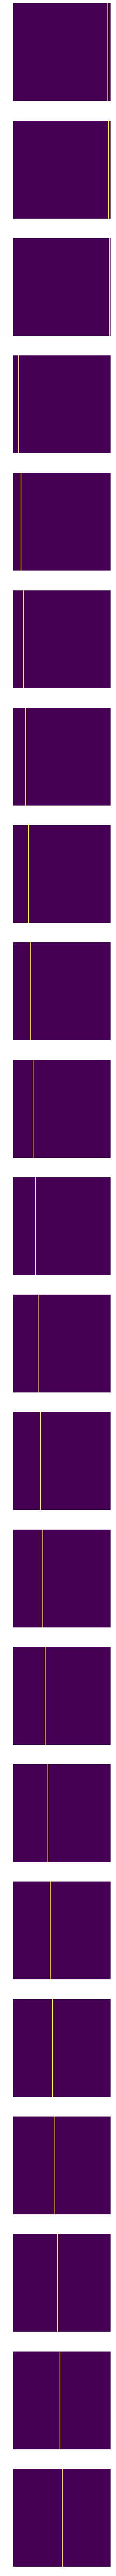

In [61]:
i = 1
fig = plt.figure(figsize=(121,121))
for image in gen_img_temp_train:
    fig.add_subplot(22, 1, i)
    plt.imshow(image)
    plt.xlim(0, data.shape[-1])
    plt.ylim(0, data.shape[-1])
    plt.axis('off')
    i += 1
plt.show()

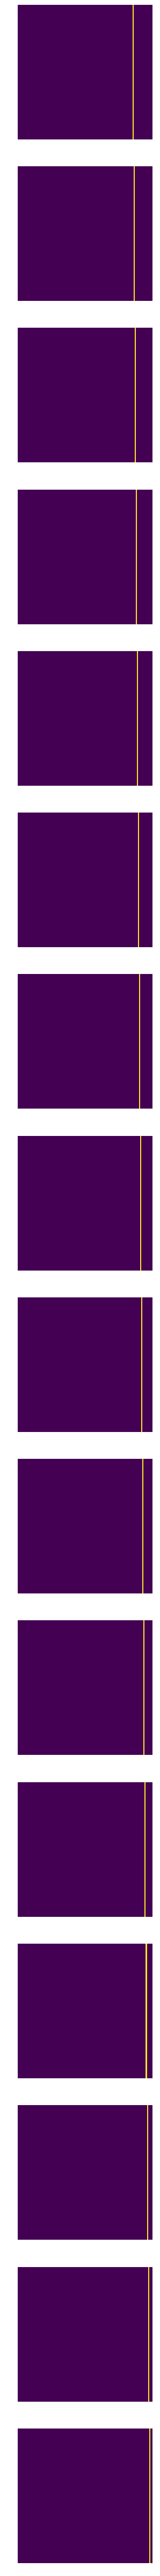

In [62]:
i = 1
fig = plt.figure(figsize=(121,121))
for image in gen_img_temp_val:
    fig.add_subplot(22, 1, i)
    plt.imshow(image)
    plt.xlim(0, data.shape[-1])
    plt.ylim(0, data.shape[-1])
    plt.axis('off')
    i += 1
plt.show()

In [64]:
val_data.shape

(48, 20, 121, 121)

In [67]:
val_embeddings_bars.shape

(912, 1024)

In [70]:
val_embeddings_bars_seq = val_embeddings_bars.reshape(-1,19,1024)

In [71]:
val_embeddings_bars_seq.shape

(48, 19, 1024)

In [73]:
val_videos_bars_seq = val_videos_bars.reshape(-1,19,121,121)

In [74]:
val_videos_bars_seq.shape

(48, 19, 121, 121)

In [ ]:
gen_inter_imgs = np.array([])
count_frames = val_videos_bars_seq.shape[1]
embed_first_frame = val_embeddings_bars_seq[0,0,:]
embed_last_frame = val_embeddings_bars_seq[0,-1,:]
for i in range(count_frames):
    lambda_curr = i/(count_frames-1)
    embed_current_frame = (1-lambda_curr)*embed_first_frame + lambda_curr*embed_last_frame
    embed_current_frame = torch.from_numpy(embed_current_frame[np.newaxis,:]).to(DEVICE).float()
    gen_current_img = decoder_network(embed_current_frame)
    gen_inter_imgs = np.vstack((gen_inter_imgs,gen_current_img.detach().cpu().numpy()[np.newaxis,:])) if gen_inter_imgs.size is not 0 else gen_current_img.detach().cpu().numpy()[np.newaxis,:]


In [90]:
gen_inter_imgs.shape

(19, 121, 121)

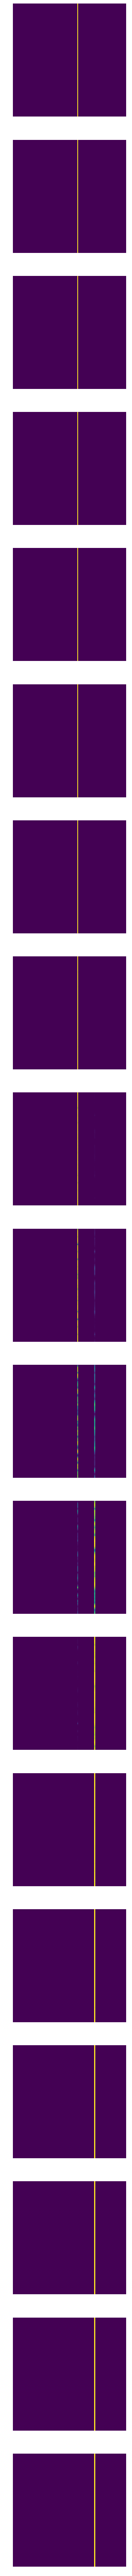

In [91]:
i = 1
fig = plt.figure(figsize=(121,121))
for image in gen_inter_imgs:
    fig.add_subplot(19, 1, i)
    plt.imshow(image)
    plt.xlim(0, data.shape[-1])
    plt.ylim(0, data.shape[-1])
    plt.axis('off')
    i += 1
plt.show()

In [93]:
val_videos_bars_seq.shape

(48, 19, 121, 121)

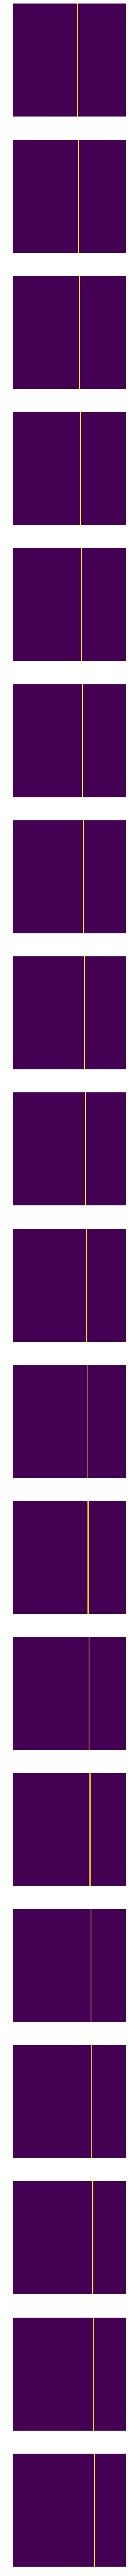

In [94]:
i=1
fig = plt.figure(figsize=(121,121))
for image in val_videos_bars_seq[0,:,:,:]:
    fig.add_subplot(19, 1, i)
    plt.imshow(image)
    plt.xlim(0, data.shape[-1])
    plt.ylim(0, data.shape[-1])
    plt.axis('off')
    i += 1
plt.show()